In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sid321axn_malicious_urls_dataset_path = kagglehub.dataset_download('sid321axn/malicious-urls-dataset')

print('Data source import complete.')


100%|██████████| 16.9M/16.9M [00:00<00:00, 117MB/s]

Extracting files...


Data source import complete.


In [ ]:
#this is the code to mount the google drive
#run this code in the google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [63]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import joblib
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('mode.chained_assignment', None)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from urllib.parse import urlparse, parse_qs
import re
import ipaddress
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

# Importing dataset

Lets load our dataset containing the malicious URL patterns

In [7]:
# file location of the dataset
data_path = '/content/drive/MyDrive/Colab Notebooks/malicious_phish.csv'
# loading our dataset
malicious_data = pd.read_csv(data_path)

# Data Understanding

In [8]:
malicious_data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [9]:
malicious_data['type'].value_counts()

,count
type,
benign,428103
defacement,96457
phishing,94111
malware,32520


In [10]:
malicious_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


# Exploratory Data Analysis

We are going to be breaking down the url adding more data to the dataset based on the URL anatomy \
![sensors-23-07760-g002.webp](attachment:56fe592a-fbbe-4d4c-8b7f-d3933bd63dbb.webp)

## Merging URL classifictions for a simpler model

Since we are building a simpler version, I would like combine the malicious link classifications into two simple types \
Either `malicious` or `benign` \
And then denote them with : \
`malicious` : 1
`benign` : 0

In [11]:
type_mapping = {
    'malware': 3,
    'defacement': 2,
    'phishing': 1,
    'benign': 0
}
malicious_data['type'] = malicious_data['type'].map(type_mapping)
malicious_data

,url,type
0,br-icloud.com.br,1
1,mp3raid.com/music/krizz_kaliko.html,0
2,bopsecrets.org/rexroth/cr/1.htm,0
3,http://www.garage-pirenne.be/index.php?option=...,2
4,http://adventure-nicaragua.net/index.php?optio...,2
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1
651188,www.gamespot.com/xbox360/action/deadspace/,1
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1


## URL Length

In [12]:
def get_url_len(url):
    return len(url)
get_url_len('mp3raid.com/music/krizz_kaliko.html')

35

In [13]:
malicious_data['url_length'] = malicious_data['url'].str.len()
malicious_data.head()

,url,type,url_length
0,br-icloud.com.br,1,16
1,mp3raid.com/music/krizz_kaliko.html,0,35
2,bopsecrets.org/rexroth/cr/1.htm,0,31
3,http://www.garage-pirenne.be/index.php?option=...,2,88
4,http://adventure-nicaragua.net/index.php?optio...,2,235


## Domain Name Length

In [14]:
def extract_domain_length(url):
    try:
        # Add 'http://' if no scheme is present
        if not url.startswith(('http://', 'https://')):
            url = 'http://' + url

        parsed_url = urlparse(url)
        domain = parsed_url.netloc

        # Return the length of the domain
        return len(domain) if domain else 0

    except Exception as e:
        return 0

extract_domain_length('br-icloud.com.br')

16

In [15]:
malicious_data['domain_length'] = malicious_data['url'].apply(extract_domain_length)


Due to some incompatible URLs we have some 0 values in `domain_length`. Lets get rid of them

In [16]:
malicious_data = malicious_data[malicious_data['domain_length'] != 0]
malicious_data[malicious_data['domain_length'] == 0]

,url,type,url_length,domain_length


Successfully deleted all the 0 values

## Check http

In [17]:
def check_http(url):
    if url.startswith('http://'):
        return 1
    else:
        return 0
check_http('http://www.garage-pirenne.be/index.php?option')

1

In [18]:
malicious_data.loc[:,'check_http'] = malicious_data['url'].apply(check_http)
malicious_data.head()

,url,type,url_length,domain_length,check_http
0,br-icloud.com.br,1,16,16,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1


## Check https

In [19]:
def check_https(url):
    if url.startswith('https://'):
        return 1
    else:
        return 0
check_https('http://www.garage-pirenne.be/index.php?option')

0

In [20]:
malicious_data.loc[:,'check_https'] = malicious_data['url'].apply(check_https)
malicious_data[malicious_data['check_https'] == 1]

,url,type,url_length,domain_length,check_http,check_https
40,https://docs.google.com/spreadsheet/viewform?f...,1,87,15,0,1
129,https://twitter.com/home?status=%E3%83%8C%E3%8...,0,290,11,0,1
491,https://medium.com/human-parts/the-laziest-com...,0,113,10,0,1
772,https://hollywoodlife.com/2015/05/14/new-york-...,0,108,17,0,1
1102,https://paytm.com/blog/vijay-shekahr-sharma-on...,0,100,9,0,1
...,...,...,...,...,...,...
555094,https://drive.google.com/uc?export=download&id...,3,80,16,0,1
555118,https://onedrive.live.com/download?cid=9BEF332...,3,108,17,0,1
555119,https://onedrive.live.com/download?cid=DD0A0EC...,3,109,17,0,1
555120,https://onedrive.live.com/download?cid=CF0C6D1...,3,108,17,0,1


## Count dots

In [21]:
def count_dots(url):
    return url.count('.')

In [22]:
malicious_data['dot_count'] = malicious_data['url'].apply(count_dots)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count
0,br-icloud.com.br,1,16,16,0,0,2
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2
...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2


## Count dashes

In [23]:
def count_dashes(url):
    return url.count('-')

In [24]:
malicious_data['dash_count'] = malicious_data['url'].apply(count_dashes)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count
0,br-icloud.com.br,1,16,16,0,0,2,1
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1
...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0


## Count underscores

In [25]:
def count_underscores(url):
    return url.count('_')

In [26]:
malicious_data['underscore_count'] = malicious_data['url'].apply(count_underscores)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count
0,br-icloud.com.br,1,16,16,0,0,2,1,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1
...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3


## Count question marks

In [27]:
def count_ques(url):
    return url.count('?')

In [28]:
malicious_data['ques_count'] = malicious_data['url'].apply(count_ques)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3,0


## Count slashes

In [29]:
def count_slashes(url):
    return url.count('/')

In [30]:
malicious_data['slash_count'] = malicious_data['url'].apply(count_slashes)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0,2
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0,3
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1,3
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0,0,3
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0,0,4
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0,0,4
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3,0,2


## Count special_chars

In [31]:
def count_special_chars(url):
    non_alpha_num = re.findall(r'\W',url)
    return len(non_alpha_num)

In [32]:
malicious_data['special_chars_count'] = malicious_data['url'].apply(count_special_chars)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0,2,4
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0,3,5
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1,3,16
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1,3,13
...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0,0,3,6
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0,0,4,8
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0,0,4,6
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3,0,2,6


## Count  digits

In [33]:
def count_digits(url):
    digits = re.findall(r'\d',url)
    return len(digits)

In [34]:
malicious_data['digits_count'] = malicious_data['url'].apply(count_digits)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0,2,4,1
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0,3,5,1
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1,3,16,7
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1,3,13,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0,0,3,6,12
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0,0,4,8,7
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0,0,4,6,3
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3,0,2,6,0


## Count Letters

In [35]:
def count_letters(url):
    letters=re.findall(r'[a-zA-Z]',url)
    return len(letters)

In [36]:
malicious_data['letters_count'] = malicious_data['url'].apply(count_letters)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3,0,13
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0,2,4,1,29
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0,3,5,1,25
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1,3,16,7,63
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1,3,13,22,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0,0,3,6,12,21
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0,0,4,8,7,29
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0,0,4,6,3,33
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3,0,2,6,0,36


## Has an IP address

In [37]:
def has_ip_address(url):
    try:
        parsed_url = urlparse(url)
        if parsed_url.hostname:
            ip = ipaddress.ip_address(parsed_url.hostname)
            return isinstance(ip, (ipaddress.IPv4Address, ipaddress.IPv6Address))
    except ValueError:
        pass
    return 0
has_ip_address("Google.com")

0

In [38]:
malicious_data['has_ip'] = malicious_data['url'].apply(has_ip_address)
malicious_data['has_ip'] = malicious_data['has_ip'].astype(int)
malicious_data['has_ip'].info()

<class 'pandas.core.series.Series'>
Index: 651173 entries, 0 to 651190
Series name: has_ip
Non-Null Count   Dtype
--------------   -----
651173 non-null  int64
dtypes: int64(1)
memory usage: 9.9 MB


## Count Parameters

In [39]:
def count_url_parameters(url):
    # Parse the URL using urlparse
    parsed_url = urlparse(url)

    # Extract the query part of the URL
    query = parsed_url.query

    # Parse the query parameters using parse_qs
    parameters = parse_qs(query)

    # Return the number of parameters
    return len(parameters)

In [40]:
malicious_data['param_count'] = malicious_data['url'].apply(count_url_parameters)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3,0,13,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0,2,4,1,29,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0,3,5,1,25,0,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1,3,16,7,63,0,4
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1,3,13,22,199,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0,0,3,6,12,21,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0,0,4,8,7,29,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0,0,4,6,3,33,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3,0,2,6,0,36,0,0


## Has php in URL

In [41]:
def check_php_in_url(url):
    # Check if the term 'php' is present in the URL (case-insensitive)
    if 'php' in url.lower():
        return 1
    else:
        return 0

In [42]:
malicious_data['has_php'] = malicious_data['url'].apply(check_php_in_url)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3,0,13,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0,2,4,1,29,0,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0,3,5,1,25,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1,3,16,7,63,0,4,1
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1,3,13,22,199,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0,0,3,6,12,21,0,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0,0,4,8,7,29,0,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0,0,4,6,3,33,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3,0,2,6,0,36,0,0,0


## Has .html in URL

In [43]:
def check_html_in_url(url):
    # Check if the term 'php' is present in the URL (case-insensitive)
    if 'html' in url.lower():
        return 1
    else:
        return 0

In [44]:
malicious_data['has_html'] = malicious_data['url'].apply(check_html_in_url)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3,0,13,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0,2,4,1,29,0,0,0,1
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0,3,5,1,25,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1,3,16,7,63,0,4,1,0
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1,3,13,22,199,0,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0,0,3,6,12,21,0,0,0,1
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0,0,4,8,7,29,0,0,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0,0,4,6,3,33,0,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3,0,2,6,0,36,0,0,0,0


## Check TLD

These are Top Level Domains that are known to be malicious (around 80-90%)

In [45]:
tld_list = [
    '.tk', '.buzz', '.xyz', '.top', '.ga', '.ml', '.info', '.cf', '.gq', '.icu', '.wang', '.live', '.host', '.shop' , '.top', '.icu', '.vip', '.id', '.cc', '.br', '.ci', '.zw', '.sx', '.mw'
]

In [46]:
def check_mal_tld(url):
    parsed_url = urlparse(url)
    netloc = parsed_url.netloc.lower()

    if any(netloc.endswith(tld) for tld in tld_list):
        return 1
    return 0

url = "http://example.xyz/path"
print(check_mal_tld(url))

1


In [47]:
malicious_data['mal_tld'] = malicious_data['url'].apply(check_mal_tld)
malicious_data[malicious_data['mal_tld'] == 1]

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,mal_tld
60,http://www.approvi.com.br/ck.htm,2,32,18,1,0,4,0,0,0,3,8,0,24,0,0,0,0,1
65,http://www.juventudelirica.com.br/index.html,2,44,26,1,0,4,0,0,0,3,8,0,36,0,0,0,1,1
99,http://www.viamanaus.com.br/index.php?option=c...,2,80,20,1,0,4,0,1,1,3,14,3,62,0,3,1,0,1
115,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,3,81,9,1,0,1,0,0,0,4,27,22,32,0,0,0,0,1
130,http://correios.com.br/para-sua-empresa/comuni...,0,136,15,1,0,2,10,0,0,7,20,1,115,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553939,http://fb-recovery-10000076733-it.tk/update_se...,3,56,29,1,0,2,3,1,0,3,9,11,35,0,0,0,0,1
554279,http://chatmusic.xyz/a3b87a035d656b088bf84f818...,3,60,13,1,0,2,0,0,0,4,7,22,31,0,0,0,0,1
554280,http://castmart.ga/~zadmin/icloud/gold_encrypt...,3,60,11,1,0,2,0,2,0,5,9,6,43,0,0,0,0,1
554998,http://tokyomangass.host/ticket.exe,3,35,17,1,0,2,0,0,0,3,6,0,29,0,0,0,0,1


## Check shortened URL

In [48]:
def is_shortened_url(url):
    shortened_services = [
        "bit.ly", "tinyurl.com", "goo.gl", "t.co", "ow.ly", "buff.ly",
        "is.gd", "adf.ly", "bit.do", "cutt.ly", "v.gd", "shorte.st",
        "bl.ink", "x.co", "s.id", "trib.al"
    ]

    parsed_url = urlparse(url)
    netloc = parsed_url.netloc.lower()

    if any(service in netloc for service in shortened_services):
        return 1
    return 0

url = "https://bit.ly/3abcxyz"
print(is_shortened_url(url))

1


In [49]:
malicious_data['shortened'] = malicious_data['url'].apply(is_shortened_url)
malicious_data[malicious_data['shortened'] == 1]

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,mal_tld,shortened
28,http://www.marketingbyinternet.com/mo/e56508df...,1,71,27,1,0,2,0,0,0,5,8,17,46,0,0,0,0,0,1
98,http://serverfault.com/questions/682832/squid-...,0,107,15,1,0,1,9,0,0,5,16,6,85,0,0,0,0,0,1
146,http://www.tiendagnulinux.com.ar/calcomanias-e...,2,86,25,1,0,4,2,1,1,3,14,2,69,0,2,0,0,0,1
160,http://mylust.com/videos/232790/hentai-slut-wi...,0,88,10,1,0,1,9,0,0,6,17,6,65,0,0,0,0,0,1
333,http://yourlust.com/videos/tight-euro-teen-ann...,0,86,12,1,0,2,9,0,0,4,16,0,70,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554075,http://gmmfuelassist.co.uk/sport/37yas27.exe,3,44,19,1,0,3,0,0,0,4,8,4,32,0,0,0,0,0,1
554076,http://gmmfuelassist.co.uk/sport/28yas27.exe,3,44,19,1,0,3,0,0,0,4,8,4,32,0,0,0,0,0,1
554077,http://gmmfuelassist.co.uk/sport/448yas27.exe,3,45,19,1,0,3,0,0,0,4,8,5,32,0,0,0,0,0,1
554078,https://gmmfuelassist.co.uk/sport/rockstar.php,3,46,19,0,1,3,0,0,0,4,8,0,38,0,0,1,0,0,1


# Neural Network Training

In [50]:
malx = malicious_data.drop(columns = {'type', 'url'})

In [51]:
x_train = malx.iloc[:, :].values
print(x_train)
print(x_train.shape)

[[16 16  0 ...  0  0  0]
 [35 11  0 ...  1  0  0]
 [31 14  0 ...  0  0  0]
 ...
 [42 16  0 ...  0  0  0]
 [45 16  0 ...  0  0  0]
 [41 17  0 ...  0  0  0]]
(651173, 18)


In [52]:
y_train = np.array(malicious_data['type'])
y_train = y_train.reshape(-1, 1)
print(y_train)
print(y_train.shape[0])

[[1]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
651173


In [53]:
model = Sequential([
    Dense(units = 13, activation = 'relu', name = 'layer_1'),
    Dense(units = 4, activation = 'linear', name = 'softmax_output') # this is supposed to be softmax, but we want more numerical accuracy so we use linear here
])

In [54]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics=['accuracy'])

In [55]:
history = model.fit(x_train, y_train, epochs = 10, validation_split = 0.2)

Epoch 1/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.8646 - loss: 0.7323 - val_accuracy: 0.3824 - val_loss: 3.0000
Epoch 2/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9176 - loss: 0.2329 - val_accuracy: 0.3708 - val_loss: 3.2418
Epoch 3/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9398 - loss: 0.1941 - val_accuracy: 0.3835 - val_loss: 3.5043
Epoch 4/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9501 - loss: 0.1660 - val_accuracy: 0.3837 - val_loss: 4.3003
Epoch 5/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9545 - loss: 0.1514 - val_accuracy: 0.3914 - val_loss: 4.2526
Epoch 6/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - accuracy: 0.9555 - loss: 0.1458 - val_accuracy: 0.3772 - val_loss: 4.9455
Epoch 7/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - accuracy: 0.9564 - loss: 0.1429 - val_accuracy: 0.3876 - val_loss: 4.7504
Epoch 8/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 

In [56]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ layer_1 (Dense)                      │ (None, 13)                  │             247 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_output (Dense)               │ (None, 4)                   │              56 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 911 (3.56 KB)

 Trainable params: 303 (1.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 608 (2.38 KB)

In [57]:
train_loss, train_acc = model.evaluate(x_train, y_train)
print(f'Training accuracy: {train_acc} with training loss of : {train_loss}')

20350/20350 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9496 - loss: 0.2080
Training accuracy: 0.8441289663314819 with training loss of : 1.187116026878357


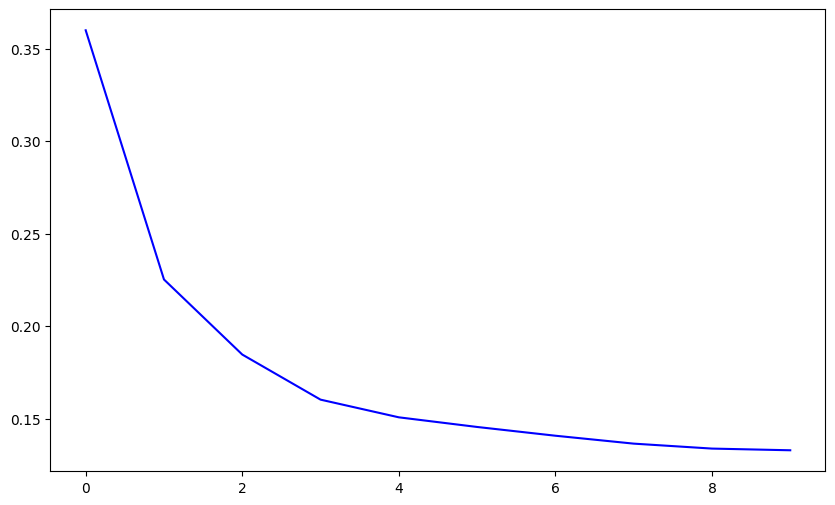

In [58]:
train_loss = history.history['loss']

epoch = np.arange(len(train_loss))

plt.figure(figsize=(10, 6))
plt.plot(epoch, train_loss, label='Training Loss', color='blue')

# Neural Network Prediction

In [59]:
malicious_data.head(1)

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,mal_tld,shortened
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3,0,13,0,0,0,0,0,0


In [60]:
x_train[0]

array([16, 16,  0,  0,  2,  1,  0,  0,  0,  3,  0, 13,  0,  0,  0,  0,  0,
        0])

In [61]:
def prepare_input(url):
    features = []

    feature_extractors = [
        get_url_len,
        extract_domain_length,
        check_http,
        check_https,
        count_dots,
        count_dashes,
        count_underscores,
        count_ques,
        count_slashes,
        count_special_chars,
        count_digits,
        count_letters,
        has_ip_address,
        count_url_parameters,
        check_php_in_url,
        check_html_in_url,
        check_mal_tld,
        is_shortened_url
    ]

    for feature_extractor in feature_extractors:
        features.append(feature_extractor(url))

    x_test = np.array(features).reshape(1, -1)

    return x_test

prepare_input('br-icloud.com.br')

array([[16, 16,  0,  0,  2,  1,  0,  0,  0,  3,  0, 13,  0,  0,  0,  0,
         0,  0]])

In [62]:
def predict(url):
    x_test = prepare_input(url)
    predictions = model.predict(x_test)
    predicted_class = np.argmax(predictions, axis=1)
    print(f'the link is of type {predicted_class}')

predict('https://kodekloud.com/blog/docker-create-image-from-container/')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
the link is of type [0]


In [65]:
# Save the model as file .pkl
joblib.dump(model, 'malicious_link_model.pkl')
print("Model saved as malicious_link_model.pkl")

Model saved as malicious_link_model.pkl
